# Классификация текстов с использованием Наивного Байесовского Классификатора

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [2]:
data = pd.read_csv('data/spam_or_not_spam.csv', sep=',')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
data.shape[0]

3000

In [4]:
# рассчитайте частоты для классов : ваш код здесь
Pspam = data['label'].value_counts()[1] / data.shape[0]
Pham = data['label'].value_counts()[0] / data.shape[0]
display(Pspam, Pham)

0.16666666666666666

0.8333333333333334

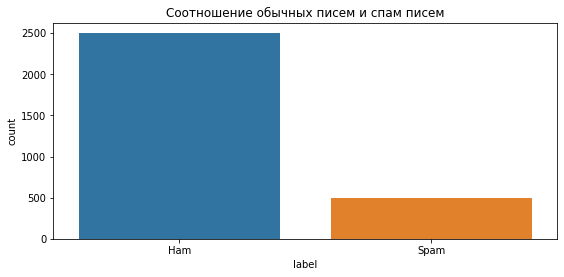

In [5]:
# визуализируйте результат: ваш код здесь
fig = plt.figure(figsize=(7, 3))
ax = fig.add_axes([0, 0, 1, 1])
sns.countplot(x=data['label'].apply(lambda x: 'Ham' if x==0 else 'Spam'), ax=ax, order=['Ham', 'Spam'])
ax.set_title('Соотношение обычных писем и спам писем');

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

Замените все пустоты (пустые строки) в данных на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [7]:
data = data.replace('', np.nan).dropna(axis=0)
data.shape

(2999, 2)

Переводим данные в векторный вид:

In [8]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [9]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [12]:
X = pd.DataFrame(X.todense()).reset_index(drop=True)
y = data['label'].reset_index(drop=True)

Разделите выборку на обучающую и тестовую, размер тестовой выборки возьмите как 0.25, параметр random_state определите со значением 42:

In [14]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [15]:
y_test.mean()

0.164

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [26]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics

model = ComplementNB(alpha=0.01)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [28]:
print(f'Показатели качества модели на тренировочной выборке ComplementNB:')
print(f'Accuracy: {round(metrics.accuracy_score(y_train, y_pred_train), 3)}')
print(f'Precision: {round(metrics.precision_score(y_train, y_pred_train), 3)}')
print(f'Recall: {round(metrics.recall_score(y_train, y_pred_train), 3)}')
print(f'_________________________________________________________________')
print(f'Показатели качества модели на тестовой выборке ComplementNB:')
print(f'Accuracy: {round(metrics.accuracy_score(y_test, y_pred_test), 3)}')
print(f'Precision: {round(metrics.precision_score(y_test, y_pred_test), 3)}')
print(f'Recall: {round(metrics.recall_score(y_test, y_pred_test), 3)}')

Показатели качества модели на тренировочной выборке ComplementNB:
Accuracy: 0.998
Precision: 1.0
Recall: 0.987
_________________________________________________________________
Показатели качества модели на тестовой выборке ComplementNB:
Accuracy: 0.995
Precision: 0.984
Recall: 0.984


Нарисуйте ROC-кривую:

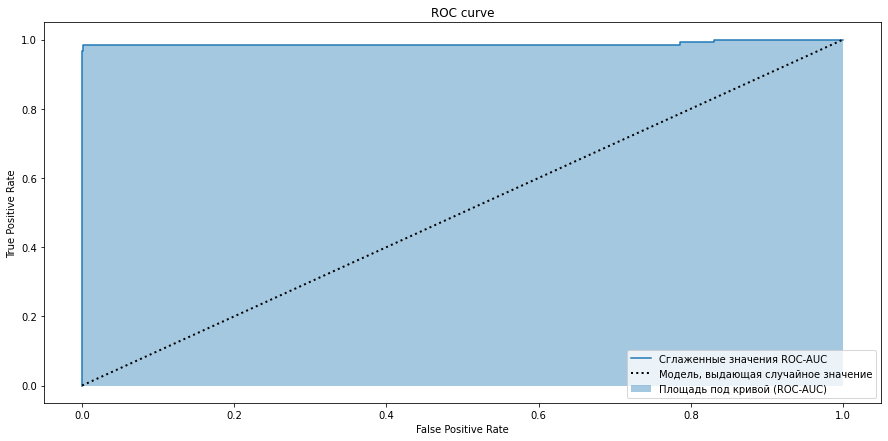

In [37]:
pred_proba = model.predict_proba(X_test)
pred_proba = pred_proba[:, 1]
false_positive_rates, true_positive_rates, threshold = metrics.roc_curve(y_test, pred_proba)

# создаём график
plt.figure(figsize=(15, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 1.15, 0.3, 0.5]} #темп обучения

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 1.73 s
Wall time: 38.1 s
accuracy на тестовом наборе: 1.00
f1_score на тестовом наборе: 0.99
Наилучшие значения гиперпараметров: {'alpha': 0.1}


In [40]:
model_best_alpha = ComplementNB(alpha=0.1)

model_best_alpha.fit(X_train, y_train)

y_pred_best_train = model_best_alpha.predict(X_train)
y_pred_best_test = model_best_alpha.predict(X_test)

print(f'Показатели качества модели на тренировочной выборке ComplementNB:')
print(f'Accuracy: {round(metrics.accuracy_score(y_train, y_pred_best_train), 3)}')
print(f'Precision: {round(metrics.precision_score(y_train, y_pred_best_train), 3)}')
print(f'Recall: {round(metrics.recall_score(y_train, y_pred_best_train), 3)}')
print(f'_________________________________________________________________')
print(f'Показатели качества модели на тестовой выборке ComplementNB:')
print(f'Accuracy: {round(metrics.accuracy_score(y_test, y_pred_best_test), 3)}')
print(f'Precision: {round(metrics.precision_score(y_test, y_pred_best_test), 3)}')
print(f'Recall: {round(metrics.recall_score(y_test, y_pred_best_test), 3)}')

Показатели качества модели на тренировочной выборке ComplementNB:
Accuracy: 0.997
Precision: 0.997
Recall: 0.984
_________________________________________________________________
Показатели качества модели на тестовой выборке ComplementNB:
Accuracy: 0.996
Precision: 0.992
Recall: 0.984


Вывод: с помощью подбора оптимального показателя параметра альфа (темп обучения) получилось улучшить показатели качества модели.